# Inspect Ego4D SCOD Test-Set

In [1]:
import csv, os, sys, re, string, json, glob, shutil, random, datetime, math, pprint
from itertools import combinations

import torch
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm

from IPython.display import HTML as html_print
from IPython.display import Markdown
from IPython.display import clear_output

# from IPython.display import Image
from PIL import Image, ImageDraw, ImageFont
from ipywidgets import Video

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set()
from matplotlib import pyplot as plt
import matplotlib.patches as patches
%pylab inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [23]:
# Use our own built-in customized COCO API.
sys.path.insert(0, "../cocoapi")

In [42]:
# from pycocotools.coco import COCO
# from pycocotools.cocoeval import COCOeval
from PythonAPI.pycocotools.coco import COCO
from PythonAPI.pycocotools.cocoeval import COCOeval
from PythonAPI.pycocotools.mask import iou as iou_func

import inspect
print("COCO API at:     {}".format(inspect.getfile(COCO)))
print("COCOeval API at: {}".format(inspect.getfile(COCOeval)))

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%reload_ext autoreload
%autoreload 2

COCO API at:     /home/telinwu/research/project_jarvis/modeling/../cocoapi/PythonAPI/pycocotools/coco.py
COCOeval API at: /home/telinwu/research/project_jarvis/modeling/../cocoapi/PythonAPI/pycocotools/cocoeval.py


# Functions

In [2]:
def red_text(text):
    return "\x1b[31m" + text + "\x1b[0m"

def blue_text(text):
    return "\x1b[94m" + text + "\x1b[0m"

def green_text(text):
    return "\x1b[32m" + text + "\x1b[0m"

def magenta_text(text):
    return "\x1b[35m" + text + "\x1b[0m"

def yellow_text(text):
    return "\x1b[93m" + text + "\x1b[0m"

def bg_yellow_text(text):
    return "\x1b[43m" + text + "\x1b[0m"

def bg_magenta_text(text):
    return "\x1b[45m" + text + "\x1b[0m"

def bg_green_text(text):
    return "\x1b[46m" + text + "\x1b[0m"

def bg_blue_text(text):
    return "\x1b[44m" + text + "\x1b[0m"

def bold_text(text):
    return "\x1b[1;128m" + text + "\x1b[0m"

In [3]:
def extract_ego4d_scod_clips(
    sampled_scod_clip,
    curr_videos_root,
    video_scenarios,
    all_narrations,
    tmp_video_name="scod_clip.mp4",
    tmp_video_folder="./media",
    extra_seconds_to_cut=None,
    ffmpeg_extract_video=True,
    verbose=False,
):
    video_uid = sampled_scod_clip["video_uid"]
    ego4d_video_path = os.path.join(
        curr_videos_root,
        "{}.mp4".format(video_uid),
    )
    summary = "N/A"
    if "narration_pass_1" in all_narrations[video_uid]:
        if len(all_narrations[video_uid]["narration_pass_1"]["summaries"]) > 0:
            summary = []
            for i in range(len(all_narrations[video_uid]["narration_pass_1"]["summaries"])):
                summary.append(all_narrations[video_uid]["narration_pass_1"]["summaries"][i]["summary_text"])
            summary = " ".join(summary)
    if verbose:
        print("{}: {}".format(bold_text("Mother video"), ego4d_video_path))
        video_scenario = video_scenarios[video_uid]
        if len(video_scenario) > 0:
            video_scenario = video_scenario[0]
        else:
            video_scenario = "N/A"
        print("{}: {}".format(bold_text("Mother video summary"), summary))
        print("{}: {}".format(bold_text("Mother video scenario"), video_scenario))

    cap = cv2.VideoCapture(ego4d_video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = float(frame_cnt) / float(fps)
    cap.release()

    if verbose:
        print(
            "The fps of the video is: {} of frame counts: {} "
            "and duration: {:.3f} sec.".format(fps, frame_cnt, duration)
        )

    pre_frame = sampled_scod_clip["pre_frame"]["frame_number"]
    pnr_frame = sampled_scod_clip["pnr_frame"]["frame_number"]
    pos_frame = sampled_scod_clip["post_frame"]["frame_number"]

    pre_secs = pre_frame / fps
    pnr_secs = pnr_frame / fps
    pos_secs = pos_frame / fps

    pre_secs = math.floor(pre_secs)
    pos_secs = math.ceil(pos_secs)
    pre_timestamp = str(datetime.timedelta(seconds=pre_secs))
    pnr_timestamp = str(datetime.timedelta(seconds=pnr_secs))
    pos_timestamp = str(datetime.timedelta(seconds=pos_secs))

    if verbose:
        print("{}:  time={} frame={}".format(bold_text("Pre-Frame"), pre_timestamp, pre_frame))
        print("{}:  time={} frame={}".format(bold_text("PNR-Frame"), pnr_timestamp, pnr_frame))
        print("{}: time={} frame={}".format(bold_text("Post-Frame"), pos_timestamp, pos_frame))

    total_video_secs = (pos_secs - pre_secs)
        
    if extra_seconds_to_cut is not None:
        assert type(extra_seconds_to_cut) is tuple and type(extra_seconds_to_cut[0]) is float
        assert len(extra_seconds_to_cut) == 2
        extra_pre_seconds_to_cut, extra_post_seconds_to_cut = extra_seconds_to_cut
        pre_timestamp = str(datetime.timedelta(seconds=max(0, pre_secs-extra_pre_seconds_to_cut)))
        pos_timestamp = str(datetime.timedelta(seconds=pos_secs+extra_post_seconds_to_cut))
        total_video_secs += (extra_pre_seconds_to_cut + extra_post_seconds_to_cut)
        if verbose:
            print(
                "{}".format(
                    red_text("Extending {} secs front and {} "
                             "secs rare.".format(extra_pre_seconds_to_cut, extra_post_seconds_to_cut)))
            )

    # pre_timestamp_secs = math.floor(float(pre_timestamp.split(":")[-1]))
    # pos_timestamp_secs = math.ceil(float(pos_timestamp.split(":")[-1]))
    pre_timestamp_secs = pre_timestamp.split(":")[-1]
    pos_timestamp_secs = pos_timestamp.split(":")[-1]

    pre_timestamp = ":".join(pre_timestamp.split(":")[:-1]) + ":" + str(pre_timestamp_secs)
    pos_timestamp = ":".join(pos_timestamp.split(":")[:-1]) + ":" + str(pos_timestamp_secs)


    if ffmpeg_extract_video:
        if not os.path.exists(tmp_video_folder):
            os.makedirs(tmp_video_folder)
        tmp_video_path = os.path.join(tmp_video_folder, tmp_video_name)
        if os.path.exists(tmp_video_path):
            os.remove(tmp_video_path)
        ffmpeg_video_cmd = (
            "/home/telinwu/ffmpeg-git-20220910-amd64-static/ffmpeg -ss {} -to {} "
            "-i {} -vcodec libx264 -c copy -loglevel panic {}".format(
                pre_timestamp,
                pos_timestamp,
                ego4d_video_path,
                tmp_video_path,
            )
        )
        os.system(ffmpeg_video_cmd)
        if verbose:
            print("{}: {}".format(bold_text(blue_text("Executed video extracting command")),
                                  blue_text(ffmpeg_video_cmd)))
            print("Total video time: {:.3f}".format(total_video_secs))

    return video_uid, {"pre_frame": pre_frame, "pnr_frame": pnr_frame, "post_frame": pos_frame}, total_video_secs
    
    
def get_scod_clipped_narrations(
    scod_clip,
    all_narrations,
    curr_videos_root,
    narration_pass="narration_pass_1",
    anchor_frame="pre",
    top_k=5,
    strict_overlapping=False,
    verbose=False,
    show_all_narrations=False,
):    
    video_uid = scod_clip["video_uid"]
    ego4d_video_path = os.path.join(
        curr_videos_root,
        "{}.mp4".format(video_uid),
    )

    cap = cv2.VideoCapture(ego4d_video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = float(frame_cnt) / float(fps)
    cap.release()
    
    clip_uid = scod_clip["clip_uid"]
    pre_frame = scod_clip["pre_frame"]
    pnr_frame = scod_clip["pnr_frame"]
    pos_frame = scod_clip["post_frame"]
    if narration_pass not in all_narrations[video_uid]:
        return []
    curr_narrations = all_narrations[video_uid][narration_pass]["narrations"]
    
    pre_frame_num = pre_frame["frame_number"]
    pnr_frame_num = pnr_frame["frame_number"]
    pos_frame_num = pos_frame["frame_number"]
    
    pre_frame_sec = round(pre_frame_num/fps, 2)
    pnr_frame_sec = round(pnr_frame_num/fps, 2)
    pos_frame_sec = round(pos_frame_num/fps, 2)
    
    closest_narrations = []
    for i in range(len(curr_narrations)-1):
        timestamp_sec = curr_narrations[i]["timestamp_sec"]
        timestamp_frame = curr_narrations[i]["timestamp_frame"]
        next_timestamp_sec = curr_narrations[i+1]["timestamp_sec"]
        next_timestamp_frame = curr_narrations[i+1]["timestamp_frame"]
        narration_text = curr_narrations[i]["narration_text"]
        anchor_frame_num = scod_clip["{}_frame".format(anchor_frame)]["frame_number"]
        
        if show_all_narrations:
            print("[{}-{}] {}".format(timestamp_frame, next_timestamp_frame, narration_text))

        closest_narrations.append((
            abs(timestamp_frame-anchor_frame_num),
            timestamp_sec, timestamp_frame,
            next_timestamp_sec, next_timestamp_frame,
            narration_text,
        ))

    closest_narrations = sorted(closest_narrations)[:top_k]
    closest_narrations = [(a, b, c, d, e) for _, a, b, c, d, e in closest_narrations]

    tagged_closest_narrations = []
    for a, b, c, d, e in closest_narrations:
        tag, tag_str = False, ""
        if (b > pre_frame_num and b < pos_frame_num) or (d > pre_frame_num and d < pos_frame_num):
            tag, tag_str = True, "(v)"

        overlapping = len(
            range(
                max(pre_frame_num, b),
                min(pos_frame_num, d) + 1
            )
        )
        if strict_overlapping and overlapping <= 0:
            continue

        if verbose:
            print(
                "[{}-{}]({}-{}) {} {}".format(
                    str(datetime.timedelta(seconds=a))[:10],
                    str(datetime.timedelta(seconds=c))[:10],
                    b, d, e, tag_str,
                )
            )
        tagged_closest_narrations.append((tag, a, b, c, d, e))
    
    return tagged_closest_narrations


def refine_or_trim_ego4d_narration(
        narration,
        remove_hand_desc=False,
    ):
    if narration is None:
        return None
    tokens = narration.split()
    character_symbol = None
    if "#" in tokens[0]:
        character_symbol = tokens[0].split("#")[-1]
    filtered_tokens = []
    for t in tokens:
        if "#" in t or (character_symbol is not None and t == character_symbol):
            continue
        if len(t) == 0:
            continue
        filtered_tokens.append(t)
    narration = " ".join(filtered_tokens)
    narration_tokens = narration.split()  # Remove white excessive white spaces.
    narration_tokens = [t for t in narration_tokens if len(t) != 0]
    narration = " ".join(narration_tokens)
    narration = narration.strip()
    if character_symbol is not None and character_symbol.lower() == "c":
        narration = "A person " + narration
    else:
        # print("No character symbol: {}".format(narration))
        pass
    if remove_hand_desc:
        regex_str = (
            "\ (?:in|with|using|into|from)\ (?:his|her|the|their|both|a)?\s*"
            "(?:gloved)?\s*(?:right|left|two|both|of)?\s*"
            "(?:his|her|the|their|gloved)?\s*"
            "(?:hands|hand|arms|arm)"
        )
        m = re.search(regex_str, narration)
        while m is not None:
            hand_str = m.group()
            narration = narration.replace(hand_str, "")
            m = re.search(regex_str, narration)
    return narration

# SCOD Data

In [4]:
# Use annotations to filter out the videos list we want.
annots_root = "/local1/hu528/ego4d_data/v1/annotations/"
annots_root = "/home/telinwu/ego4d_data/v1/annotations/"
curr_videos_root = "/local1/hu528/ego4d_data/v1/full_scale"

video_info_file = "/local1/hu528/ego4d_data/ego4d.json"
video_info = json.load(open(video_info_file))
info_videos = video_info["videos"]
video_scenarios = {x["video_uid"]: x["scenarios"] for x in info_videos}

all_narrations_file = os.path.join(annots_root, "narration.json")
all_narrations = json.load(open(all_narrations_file))

In [5]:
# Get the SCOD challenge train-val sets.
scod_train_file = "fho_scod_train.json"
scod_train_file = os.path.join(annots_root, scod_train_file)
scod_train_data = json.load(open(scod_train_file))
scod_train_clips = scod_train_data["clips"]

scod_val_file = "fho_scod_val.json"
scod_val_file = os.path.join(annots_root, scod_val_file)
scod_val_data = json.load(open(scod_val_file))
scod_val_clips = scod_val_data["clips"]

scod_test_file = "fho_scod_test_unannotated.json"
scod_test_file = os.path.join(annots_root, scod_test_file)
scod_test_data = json.load(open(scod_test_file))
scod_test_clips = scod_test_data["clips"]

scod_clips = {
    "train": scod_train_clips,
    "val": scod_val_clips,
    "test": scod_test_clips,
}

downloaded_video_id_and_paths = {
    x.split(".mp4")[0]: os.path.join(curr_videos_root, x)
    for x in os.listdir(curr_videos_root) if ".mp4" in x
}
print("Currently we downloaded {} ego4d videos.".format(len(downloaded_video_id_and_paths)))

downloaded_scod_clips = {
    "train": [],
    "val": [],
    "test": [],
}
split_video_uids = {
    "train": [],
    "val": [],
    "test": [],
}
for split in scod_clips:
    for scod_clip in scod_clips[split]:
        video_uid = scod_clip["video_uid"]
        if video_uid in downloaded_video_id_and_paths:
            downloaded_scod_clips[split].append(scod_clip)
        if video_uid not in split_video_uids[split]:
            split_video_uids[split].append(video_uid)
    print(
        "There are {}/{} clips available for scod {}.".format(
            len(downloaded_scod_clips[split]),
            len(scod_clips[split]),
            split
        )
    )
    print("The {} split has {} unique Ego4D videos.".format(split, len(split_video_uids[split])))

Currently we downloaded 926 ego4d videos.
There are 19071/19071 clips available for scod train.
The train split has 457 unique Ego4D videos.
There are 12801/12801 clips available for scod val.
The val split has 346 unique Ego4D videos.
There are 662898/662898 clips available for scod test.
The test split has 333 unique Ego4D videos.


## Inspections (Test Set)

In [6]:
pre_generated_captions_file = (
    "/home/telinwu/research/project_jarvis/modeling/glip_result_json_files/scod_testset_lavis_captions.json"
)
pre_generated_captions_testset = json.load(open(pre_generated_captions_file))

In [7]:
image_root = "/local1/telinwu/research/resources/Ego4D/ego4d_scod_challenge/pre_pnr_post_frames"
split = "test"

Mother video: 6d3939f5-5636-43c7-94bb-86318392bd2d
--------------------------------------------------
Frame: pre_frame  Number: 11764


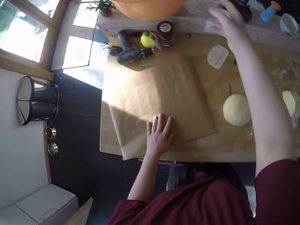

--------------------------------------------------
Frame: pnr_frame  Number: 14859


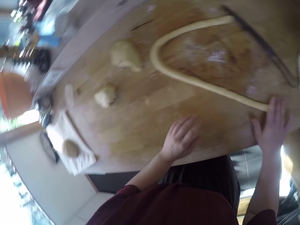

BLIPv2-Caption-1: a person makes dough with a knife on a wooden table
--------------------------------------------------
Frame: post_frame  Number: 15331


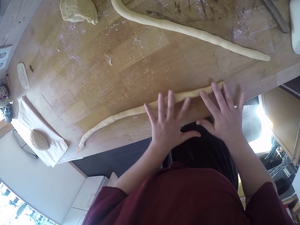

--------------------------------------------------


In [8]:
rand_idx = np.random.randint(len(downloaded_scod_clips[split]))
resize_image_width = 300

curr_scod_clip = downloaded_scod_clips[split][rand_idx]
video_uid = curr_scod_clip["video_uid"]
print("Mother video: {}".format(video_uid))
print("-"*50)
for fr in ["pre", "pnr", "post"]:
    fr_name = "{}_frame".format(fr)
    fr_info = curr_scod_clip[fr_name]
    frame_num = fr_info["frame_number"]
    image_path = os.path.join(image_root, video_uid, str(frame_num)+".jpg")
    print("{} {}  {} {}".format(bold_text("Frame:"), fr_name, bold_text("Number:"), frame_num))
    # print(image_path)
    img = Image.open(image_path)
    if resize_image_width is not None:
        wpercent = (resize_image_width / float(img.size[0]))
        hsize = int((float(img.size[1]) * float(wpercent)))
        img = img.resize(
            (resize_image_width, hsize), Image.Resampling.LANCZOS)
    display(img)
    if fr == "pnr":
        file_name = os.path.join(video_uid, str(frame_num)+".jpg")
        assert file_name in pre_generated_captions_testset, (
            "File name: `{}` does not have pre-generated captions!".format(file_name)
        )
        curr_pre_generated_captions = pre_generated_captions_testset[file_name]
        for idx in range(len(curr_pre_generated_captions)):
            curr_curr_pre_generated_caption = curr_pre_generated_captions[idx]
            print("{} {}".format(bold_text(blue_text("BLIPv2-Caption-{}:".format(idx+1))),
                                 blue_text(curr_curr_pre_generated_caption)))
    print("-"*50)

## Inspections (Val Set)

In [762]:
def draw_bbox_on_image(
    image,
    bbox_list,
    object_name=None,
    bbox_width=2,
    label_font_size=12,
    outline_color="white"
):
    # Read images and draw rectangles.
    if type(image) is str:  # An image path.
        im = Image.open(image)
    else:
        im = image
    draw = ImageDraw.Draw(im)
    # Get a font.
    font = ImageFont.truetype("../all_visualizations/arial.ttf", size=label_font_size)
    offset = 2
    
    verts = bbox_list
    draw.rectangle(
        [(verts[0], verts[1]), (verts[0] + verts[2], verts[1] + verts[3])],
        width=bbox_width,
        outline=outline_color,
    )
    # Draw text with black background.
    text = object_name
    if text is None:
        text = "NULL"
    text_width, text_height = font.getsize(text)
    draw.rectangle(
        (
            verts[0] + offset,
            verts[1] + offset,
            verts[0] + 2 * offset + text_width,
            verts[1] + 2 * offset + text_height,
        ),
        fill="black",
    )
    draw.text(
        (verts[0] + offset, verts[1] + offset),
        text,
        fill=(255, 255, 255),
        font=font,
    )
    
    return im


def plot_gt_bboxes_for_single_scod_clip(
    clip,
    resize_image_width=None,
    image_root="/local1/telinwu/research/resources/Ego4D/ego4d_scod_challenge/pre_pnr_post_frames/",
    pre_generated_captions=None,
    model_pred_bboxes=None,
    narration=None,
    bbox_width=3,
    label_font_size=30,
):
    video_uid = clip["video_uid"]
    _id = [video_uid]
    print("-"*50)
    for fr in ["pre", "pnr", "post"]:
        fr_name = "{}_frame".format(fr)
        fr_num = clip[fr_name]["frame_number"]
        img_path = os.path.join(
            image_root,
            "{}/{}.jpg".format(video_uid, fr_num)
        )
        assert os.path.exists(img_path)
        bboxed_frame_image = Image.open(img_path)
        print(img_path)

        all_bbox_info = clip[fr_name]["bbox"]
        bbox_ooc, bbox_tool = None, None
        for bbox_info in all_bbox_info:
            if bbox_info["object_type"] in ["object_of_change", "tool"]:
                bbox = bbox_info["bbox"]
                bbox = [
                    bbox["x"], bbox["y"], bbox["width"], bbox["height"],
                ]
                outline_color = "white"
                bbox_text = "NULL"
                if bbox_info["object_type"] == "object_of_change":
                    outline_color = "red"
                    bbox_text = "OUC"
                    bbox_ooc = bbox
                elif bbox_info["object_type"] == "tool":
                    outline_color = "green"
                    bbox_text = "TOOL"
                    bbox_tool = bbox
                bboxed_frame_image = draw_bbox_on_image(
                    bboxed_frame_image,
                    bbox,
                    object_name=bbox_text,
                    bbox_width=bbox_width,
                    label_font_size=label_font_size,
                    outline_color=outline_color,
                )
            pass
        if model_pred_bboxes is not None:
            for model_key in model_pred_bboxes:
                preds = model_pred_bboxes[model_key]
                if "1" in model_key:
                    outline_color = "blue"
                else:
                    outline_color = "cyan"
                for pred in preds:
                    pred_bbox = pred["bbox"]
                    obj_type = "OUC" if pred["category_id"] == 1 else "TOOL"
                    bboxed_frame_image = draw_bbox_on_image(
                        bboxed_frame_image,
                        pred_bbox,
                        object_name="{}:{}".format(model_key, obj_type),
                        bbox_width=bbox_width,
                        label_font_size=label_font_size,
                        outline_color=outline_color,
                    )
                pass
            pass
        if (
            resize_image_width is not None
            and (type(resize_image_width) is int or
                 type(resize_image_width) is float)
        ):
            wpercent = (resize_image_width / float(bboxed_frame_image.size[0]))
            hsize = int((float(bboxed_frame_image.size[1]) * float(wpercent)))
            bboxed_frame_image = bboxed_frame_image.resize((resize_image_width, hsize), Image.Resampling.LANCZOS)
        display(bboxed_frame_image)
        
        if pre_generated_captions is not None:
            if narration is None:
                narration = "Either un-narrated or not used!"
            print("{} {}".format(bold_text(magenta_text("Closest Narration:")),
                                 magenta_text(narration)))
            file_name = os.path.join(video_uid, str(frame_num)+".jpg")
            if file_name not in pre_generated_captions:
                curr_pre_generated_captions = ["Not generated yet!"]
            else:
                curr_pre_generated_captions = pre_generated_captions[file_name]
            for idx in range(len(curr_pre_generated_captions)):
                curr_curr_pre_generated_caption = curr_pre_generated_captions[idx]
                print("{} {}".format(bold_text(blue_text(" BLIPv2-Caption-{}:".format(idx+1))),
                                     blue_text(curr_curr_pre_generated_caption)))
        pass
        if (
            bbox_ooc is not None
            and bbox_tool is not None
        ):
            iou_curr = iou_func(
                [bbox_ooc], [bbox_tool], [0]
            )[0]
            iou_curr = float(iou_curr)
            print("{}{:.3f}".format(bold_text(magenta_text("OOC-Tool BBox IOU = ")), iou_curr))
        print("-"*50)
    pass
        
        
def extract_ego4d_scod_clips(
    sampled_scod_clip,
    curr_videos_root,
    video_scenarios,
    all_narrations,
    tmp_video_name="scod_clip.mp4",
    tmp_video_folder="./media",
    extra_seconds_to_cut=None,
    ffmpeg_extract_video=True,
    verbose=False,
):
    video_uid = sampled_scod_clip["video_uid"]
    ego4d_video_path = os.path.join(
        curr_videos_root,
        "{}.mp4".format(video_uid),
    )
    summary = "N/A"
    if "narration_pass_1" in all_narrations[video_uid]:
        if len(all_narrations[video_uid]["narration_pass_1"]["summaries"]) > 0:
            summary = []
            for i in range(len(all_narrations[video_uid]["narration_pass_1"]["summaries"])):
                summary.append(all_narrations[video_uid]["narration_pass_1"]["summaries"][i]["summary_text"])
            summary = " ".join(summary)
    if verbose:
        print("{}: {}".format(bold_text("Mother video"), ego4d_video_path))
        video_scenario = video_scenarios[video_uid]
        if len(video_scenario) > 0:
            video_scenario = video_scenario[0]
        else:
            video_scenario = "N/A"
        print("{}: {}".format(bold_text("Mother video summary"), summary))
        print("{}: {}".format(bold_text("Mother video scenario"), video_scenario))

    cap = cv2.VideoCapture(ego4d_video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = float(frame_cnt) / float(fps)
    cap.release()

    if verbose:
        print(
            "The fps of the video is: {} of frame counts: {} "
            "and duration: {:.3f} sec.".format(fps, frame_cnt, duration)
        )

    pre_frame = sampled_scod_clip["pre_frame"]["frame_number"]
    pnr_frame = sampled_scod_clip["pnr_frame"]["frame_number"]
    pos_frame = sampled_scod_clip["post_frame"]["frame_number"]

    pre_secs = pre_frame / fps
    pnr_secs = pnr_frame / fps
    pos_secs = pos_frame / fps

    pre_secs = math.floor(pre_secs)
    pos_secs = math.ceil(pos_secs)
    pre_timestamp = str(datetime.timedelta(seconds=pre_secs))
    pnr_timestamp = str(datetime.timedelta(seconds=pnr_secs))
    pos_timestamp = str(datetime.timedelta(seconds=pos_secs))

    if verbose:
        print("{}:  time={} frame={}".format(bold_text("Pre-Frame"), pre_timestamp, pre_frame))
        print("{}:  time={} frame={}".format(bold_text("PNR-Frame"), pnr_timestamp, pnr_frame))
        print("{}: time={} frame={}".format(bold_text("Post-Frame"), pos_timestamp, pos_frame))

    total_video_secs = (pos_secs - pre_secs)
        
    if extra_seconds_to_cut is not None:
        assert type(extra_seconds_to_cut) is tuple and type(extra_seconds_to_cut[0]) is float
        assert len(extra_seconds_to_cut) == 2
        extra_pre_seconds_to_cut, extra_post_seconds_to_cut = extra_seconds_to_cut
        pre_timestamp = str(datetime.timedelta(seconds=max(0, pre_secs-extra_pre_seconds_to_cut)))
        pos_timestamp = str(datetime.timedelta(seconds=pos_secs+extra_post_seconds_to_cut))
        total_video_secs += (extra_pre_seconds_to_cut + extra_post_seconds_to_cut)
        if verbose:
            print(
                "{}".format(
                    red_text("Extending {} secs front and {} "
                             "secs rare.".format(extra_pre_seconds_to_cut, extra_post_seconds_to_cut)))
            )

    # pre_timestamp_secs = math.floor(float(pre_timestamp.split(":")[-1]))
    # pos_timestamp_secs = math.ceil(float(pos_timestamp.split(":")[-1]))
    pre_timestamp_secs = pre_timestamp.split(":")[-1]
    pos_timestamp_secs = pos_timestamp.split(":")[-1]

    pre_timestamp = ":".join(pre_timestamp.split(":")[:-1]) + ":" + str(pre_timestamp_secs)
    pos_timestamp = ":".join(pos_timestamp.split(":")[:-1]) + ":" + str(pos_timestamp_secs)


    if ffmpeg_extract_video:
        if not os.path.exists(tmp_video_folder):
            os.makedirs(tmp_video_folder)
        tmp_video_path = os.path.join(tmp_video_folder, tmp_video_name)
        if os.path.exists(tmp_video_path):
            os.remove(tmp_video_path)
        ffmpeg_video_cmd = (
            "/home/telinwu/ffmpeg-git-20220910-amd64-static/ffmpeg -ss {} -to {} "
            "-i {} -vcodec libx264 -c copy -loglevel panic {}".format(
                pre_timestamp,
                pos_timestamp,
                ego4d_video_path,
                tmp_video_path,
            )
        )
        os.system(ffmpeg_video_cmd)
        if verbose:
            print("{}: {}".format(bold_text(blue_text("Executed video extracting command")),
                                  blue_text(ffmpeg_video_cmd)))
            print("Total video time: {:.3f}".format(total_video_secs))

    return video_uid, {"pre_frame": pre_frame, "pnr_frame": pnr_frame, "post_frame": pos_frame}, total_video_secs
    
    
def get_scod_clipped_narrations(
    scod_clip,
    all_narrations,
    curr_videos_root,
    narration_pass="narration_pass_1",
    anchor_frame="pre",
    top_k=5,
    strict_overlapping=False,
    verbose=False,
    show_all_narrations=False,
):    
    video_uid = scod_clip["video_uid"]
    ego4d_video_path = os.path.join(
        curr_videos_root,
        "{}.mp4".format(video_uid),
    )

    cap = cv2.VideoCapture(ego4d_video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = float(frame_cnt) / float(fps)
    cap.release()
    
    clip_uid = scod_clip["clip_uid"]
    pre_frame = scod_clip["pre_frame"]
    pnr_frame = scod_clip["pnr_frame"]
    pos_frame = scod_clip["post_frame"]
    if narration_pass not in all_narrations[video_uid]:
        return []
    curr_narrations = all_narrations[video_uid][narration_pass]["narrations"]
    
    pre_frame_num = pre_frame["frame_number"]
    pnr_frame_num = pnr_frame["frame_number"]
    pos_frame_num = pos_frame["frame_number"]
    
    pre_frame_sec = round(pre_frame_num/fps, 2)
    pnr_frame_sec = round(pnr_frame_num/fps, 2)
    pos_frame_sec = round(pos_frame_num/fps, 2)
    
    closest_narrations = []
    for i in range(len(curr_narrations)-1):
        timestamp_sec = curr_narrations[i]["timestamp_sec"]
        timestamp_frame = curr_narrations[i]["timestamp_frame"]
        next_timestamp_sec = curr_narrations[i+1]["timestamp_sec"]
        next_timestamp_frame = curr_narrations[i+1]["timestamp_frame"]
        narration_text = curr_narrations[i]["narration_text"]
        anchor_frame_num = scod_clip["{}_frame".format(anchor_frame)]["frame_number"]
        
        if show_all_narrations:
            print("[{}-{}] {}".format(timestamp_frame, next_timestamp_frame, narration_text))

        closest_narrations.append((
            abs(timestamp_frame-anchor_frame_num),
            timestamp_sec, timestamp_frame,
            next_timestamp_sec, next_timestamp_frame,
            narration_text,
        ))

    closest_narrations = sorted(closest_narrations)[:top_k]
    closest_narrations = [(a, b, c, d, e) for _, a, b, c, d, e in closest_narrations]

    tagged_closest_narrations = []
    for a, b, c, d, e in closest_narrations:
        tag, tag_str = False, ""
        if (b > pre_frame_num and b < pos_frame_num) or (d > pre_frame_num and d < pos_frame_num):
            tag, tag_str = True, "(v)"

        overlapping = len(
            range(
                max(pre_frame_num, b),
                min(pos_frame_num, d) + 1
            )
        )
        if strict_overlapping and overlapping <= 0:
            continue

        if verbose:
            print(
                "[{}-{}]({}-{}) {} {}".format(
                    str(datetime.timedelta(seconds=a))[:10],
                    str(datetime.timedelta(seconds=c))[:10],
                    b, d, e, tag_str,
                )
            )
        tagged_closest_narrations.append((tag, a, b, c, d, e))
    
    return tagged_closest_narrations


def refine_or_trim_ego4d_narration(
        narration,
        remove_hand_desc=False,
):
    if narration is None:
        return None
    tokens = narration.split()
    character_symbol = None
    if "#" in tokens[0]:
        character_symbol = tokens[0].split("#")[-1]
    filtered_tokens = []
    for t in tokens:
        if "#" in t or (character_symbol is not None and t == character_symbol):
            continue
        if len(t) == 0:
            continue
        filtered_tokens.append(t)
    narration = " ".join(filtered_tokens)
    narration_tokens = narration.split()  # Remove white excessive white spaces.
    narration_tokens = [t for t in narration_tokens if len(t) != 0]
    narration = " ".join(narration_tokens)
    narration = narration.strip()
    if character_symbol is not None and character_symbol.lower() == "c":
        narration = "A person " + narration
    else:
        # print("No character symbol: {}".format(narration))
        pass
    if remove_hand_desc:
        regex_str = (
            "\ (?:in|with|using|into|from)\ (?:his|her|the|their|both|a)?\s*"
            "(?:gloved)?\s*(?:right|left|two|both|of)?\s*"
            "(?:his|her|the|their|gloved)?\s*"
            "(?:hands|hand|arms|arm)"
        )
        m = re.search(regex_str, narration)
        while m is not None:
            hand_str = m.group()
            narration = narration.replace(hand_str, "")
            m = re.search(regex_str, narration)
    return narration

In [11]:
split = "train"
split_clips = downloaded_scod_clips[split]

pre_generated_captions_file = (
    "/home/telinwu/research/project_jarvis/modeling/glip_result_json_files/scod_{}_lavis_captions.json".format(split)
)
pre_generated_captions_trainval = json.load(open(pre_generated_captions_file))
# pre_generated_captions_trainval = None

In [12]:
keyed_clips = {}
for clip in split_clips:
    video_uid = clip["video_uid"]
    _id = [video_uid]
    for fr in ["pre", "pnr", "post"]:
        fr_name = "{}_frame".format(fr)
        fr_num = clip[fr_name]["frame_number"]
        _id.append(str(fr_num))
    _id = "_".join(_id)
    keyed_clips[_id] = clip

Mother video: 6d3939f5-5636-43c7-94bb-86318392bd2d
--------------------------------------------------


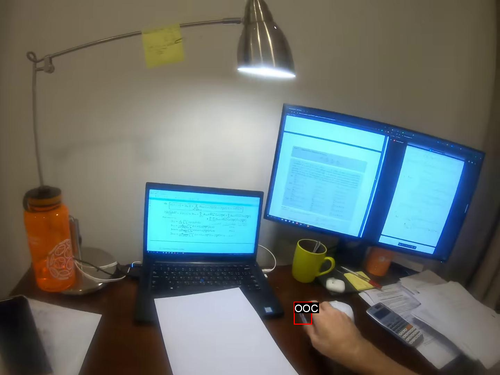

Closest Narration: A person picks the pen from the table with his right hand.
 BLIPv2-Caption-1: Not generated yet!
--------------------------------------------------


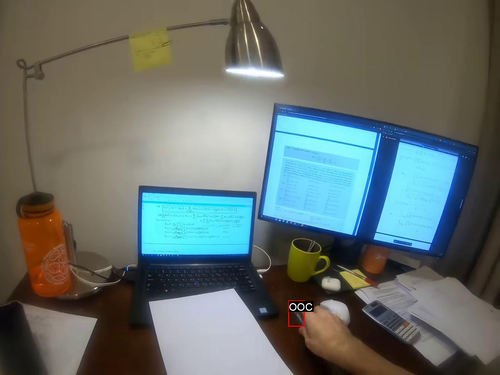

Closest Narration: A person picks the pen from the table with his right hand.
 BLIPv2-Caption-1: Not generated yet!
--------------------------------------------------


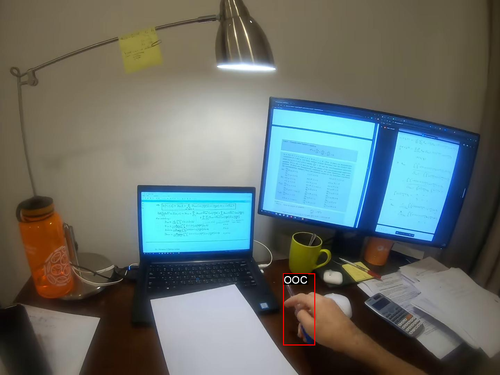

Closest Narration: A person picks the pen from the table with his right hand.
 BLIPv2-Caption-1: Not generated yet!
--------------------------------------------------


In [20]:
rand_idx = np.random.randint(len(downloaded_scod_clips[split]))
resize_image_width = 300

sampled_scod_clip = downloaded_scod_clips[split][rand_idx]
video_uid = curr_scod_clip["video_uid"]
print("Mother video: {}".format(video_uid))

closest_narrations = get_scod_clipped_narrations(
    sampled_scod_clip,
    all_narrations,
    curr_videos_root="/local1/hu528/ego4d_data/v1/full_scale",
    narration_pass="narration_pass_1",
    anchor_frame="pnr",
    top_k=5,
    strict_overlapping=False,
    verbose=False,
    show_all_narrations=False,
)
narration = None
if len(closest_narrations) > 0:
    closest_narration = closest_narrations[0][-1]
    narration = refine_or_trim_ego4d_narration(closest_narration)

plot_gt_bboxes_for_single_scod_clip(
    sampled_scod_clip,
    resize_image_width=500,
    image_root="/local1/telinwu/research/resources/Ego4D/ego4d_scod_challenge/pre_pnr_post_frames/",
    pre_generated_captions=pre_generated_captions_trainval,
    narration=narration,
)

### If know the keyed-id

--------------------------------------------------


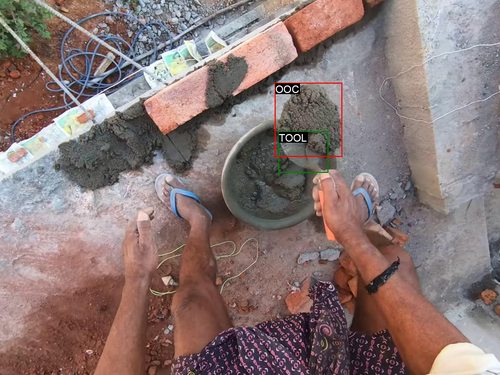

OOC-Tool BBox IOU = 0.255
--------------------------------------------------


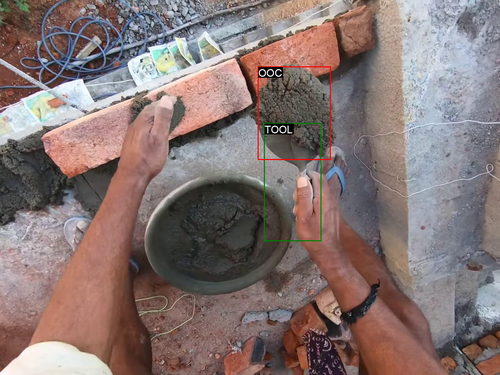

OOC-Tool BBox IOU = 0.310
--------------------------------------------------


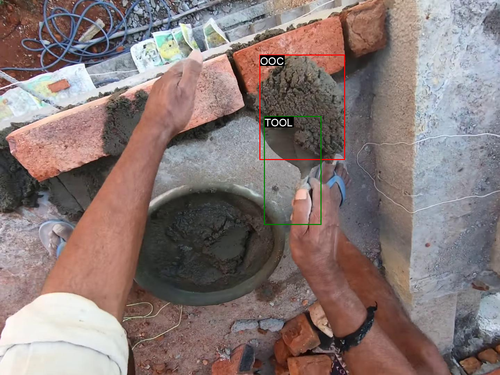

OOC-Tool BBox IOU = 0.281
--------------------------------------------------


In [34]:
ego_id = "12bf3659-40c4-4094-a4d3-507ec04bc512_10780_10811_10929"
ego_id = "c396d137-e956-4a7f-ab2e-5a0b29c51afa_14702_14712_14782"
ego_id = "aa746a74-9e1b-49c6-9e27-f0c8d2f58642_2350_2358_2474"  # slightly touching
ego_id = "5af8e5f9-2a28-485c-9604-6f5f9f290c82_108907_108919_109011"  # largely overlapping, grass is too large!
ego_id = "e406c375-245c-419e-9525-652f61eda7d3_10528_10542_10655"  # largely overlapping, indeed no need to touch
ego_id = "e00d8164-9996-48ed-8645-bb88ab30cc09_1528_1540_1543"  # largely overlapping, ...

if ego_id == "c396d137-e956-4a7f-ab2e-5a0b29c51afa_14702_14712_14782":
    keyed_clips[ego_id]["pnr_frame"]["bbox"].append({
        "bbox": {"height": 330.4, "width": 278.37, "x": 881.23, "y": 255.23},
        "object_type": "tool",
    })

plot_gt_bboxes_for_single_scod_clip(
    keyed_clips[ego_id],
    resize_image_width=500,
    image_root="/local1/telinwu/research/resources/Ego4D/ego4d_scod_challenge/pre_pnr_post_frames/",
    pre_generated_captions=None,
    narration=None,
)

if ego_id == "c396d137-e956-4a7f-ab2e-5a0b29c51afa_14702_14712_14782":
    keyed_clips[ego_id]["pnr_frame"]["bbox"].pop(-1)

# Cherry-Picking Examples

In [35]:
def create_coco_gt_pred_dict(
    coco_gt_file,
    coco_pred_file,
    compensate_missing_pred=False,
):
    preds = json.load(open(coco_pred_file))
    gts = json.load(open(coco_gt_file))["annotations"]

    gt_dict = {}
    for gt in gts:
        image_id = gt["image_id"]
        if image_id not in gt_dict:
            gt_dict[image_id] = []
        gt_dict[image_id].append(gt["bbox"])
    print("Num GT Instances: {}".format(len(gt_dict)))

    preds_dict = {}
    for pred in preds:
        image_id = pred["image_id"]
        if image_id not in preds_dict:
            preds_dict[image_id] = []
        preds_dict[image_id].append({
            "bbox": pred["bbox"],
            "score": pred["score"],
            "category_id": pred["category_id"],
            "image_id": pred["image_id"],
        })
    print("Num Pred Instances: {}".format(len(preds_dict)))
    
    assert len(gt_dict) >= len(preds_dict), (
        "More prediction ids than gt ids, sure the correct file(s)?"
    )

    joint_dict = {}
    for image_id in sorted(gt_dict):
        if compensate_missing_pred and image_id not in preds_dict:
            preds_dict[image_id] = [{
                "bbox": [0, 0, 1, 1],
                "score": 1.0,
                "category_id": 1,
                "image_id": image_id,
            }]
        preds_dict[image_id] = sorted(
            preds_dict[image_id],
            key=lambda x: x["score"],
            reverse=True,
        )
        joint_dict[image_id] = {
            "gt_bboxes": gt_dict[image_id],
            "pred_bboxes": preds_dict[image_id],
        }
    
    print("Num Joint Instances: {}".format(len(joint_dict)))
    return joint_dict


def get_ndarray_coco_results(coco_pred_file):
    # [Nx7] where each row contains {imageID,x1,y1,w,h,score,class}
    if type(coco_pred_file) == str:
        preds = json.load(open(coco_pred_file))
    else:
        preds = coco_pred_file
    arrs = []
    for pred in preds:
        image_id = pred["image_id"]
        x1 = pred["bbox"][0]
        y1 = pred["bbox"][1]
        w  = pred["bbox"][2]
        h  = pred["bbox"][3]
        score = pred["score"]
        label = pred["category_id"]
        arr = [image_id, x1, y1, w, h, score, label]
        arrs.append(arr)
    return np.asarray(arrs)

In [36]:
def get_per_frame_type_ndarray_coco_results(
    coco_gt_file,
    coco_pred_file,
    scod_clips,
    forced_frame_types=None,
    fully_narrated_image_ids=None,
    verbose=False
):
    if type(coco_pred_file) == str:
        preds = json.load(open(coco_pred_file))
    else:
        preds = coco_pred_file
    if fully_narrated_image_ids is not None:
        preds = [x for x in preds if x["image_id"] in fully_narrated_image_ids]
        
    if type(coco_gt_file) == str:
        gt_data = json.load(open(coco_gt_file))
        gts, anns = gt_data["images"], gt_data["annotations"]
    else:
        gts, anns = coco_gt_file
    if fully_narrated_image_ids is not None:
        gts = [x for x in gts if x["id"] in fully_narrated_image_ids]
        anns = [x for x in anns if x["image_id"] in fully_narrated_image_ids]
        
    frame_type_dict = {}
    for scod in scod_clips:
        video_uid = scod["video_uid"]
        for fr in ["pre", "pnr", "post"]:
            frame_type = "{}_frame".format(fr)
            if frame_type not in scod:
                continue
            frame_num = scod[frame_type]["frame_number"]
            key = "{}_{}".format(video_uid, frame_num)
            if key not in frame_type_dict:
                frame_type_dict[key] = []
            if frame_type not in frame_type_dict[key]:
                frame_type_dict[key].append(frame_type)
            pass
        pass

    id_to_frame_mappings = {}
    for gt in gts:
        file_name = gt["file_name"].split(".")[0]
        video_uid, frame_num = file_name.split("/")
        key = "{}_{}".format(video_uid, frame_num)
        if key not in frame_type_dict:
            raise ValueError(
                "Key {} not in scod clips, sure the right file(s)?".format(key)
            )
        image_id = gt["id"]
        if image_id not in id_to_frame_mappings:
            id_to_frame_mappings[image_id] = []
        id_to_frame_mappings[image_id] += frame_type_dict[key]
        
    per_frame_type_anns = {}
    for ann in anns:
        image_id = ann["image_id"]
        frame_types = id_to_frame_mappings[image_id]
        for frame_type in frame_types:
            if frame_type not in per_frame_type_anns:
                per_frame_type_anns[frame_type] = []
            per_frame_type_anns[frame_type].append(ann)
        pass
    
    per_frame_type_preds = {}
    for pred in preds:
        image_id = pred["image_id"]
        frame_types = id_to_frame_mappings[image_id]
        for frame_type in frame_types:
            if frame_type not in per_frame_type_preds:
                per_frame_type_preds[frame_type] = []
            per_frame_type_preds[frame_type].append(pred)
        pass
    
    per_frame_type_pred_ndarrays = {}
    for fr in ["pre", "pnr", "post"]:
        frame_type = "{}_frame".format(fr)
        if forced_frame_types is not None and fr not in forced_frame_types:
            continue
        per_frame_type_pred_ndarrays[frame_type] = get_ndarray_coco_results(
            per_frame_type_preds[frame_type]
        )
        if verbose:
            print("{}'s cnt = {}".format(frame_type, len(per_frame_type_preds[frame_type])))
    
    return per_frame_type_pred_ndarrays, per_frame_type_anns

In [44]:
def check_gt_pred_match_on_file(
    coco_gt_file,
    coco_pred_file,
):
    # print("Checking GT and Pred files matching...")
    if type(coco_gt_file) is str:
        coco_gt_data = json.load(open(coco_gt_file))
    else:
        coco_gt_data = coco_gt_file
    if type(coco_pred_file) is str:
        coco_pred_data = json.load(open(coco_pred_file))
    elif type(coco_pred_file) == np.ndarray:
        _coco = COCO(verbose=False)
        coco_pred_data = _coco.loadNumpyAnnotations(coco_pred_file)
    else:
        coco_pred_data = coco_pred_file
    gt_image_ids = {x["id"]: True for x in coco_gt_data["images"]}
    pred_image_ids = [x["image_id"] for x in coco_pred_data]
    pred_image_ids = list(set(pred_image_ids))
    for _id in pred_image_ids:
        if _id not in gt_image_ids:
            raise ValueError(
                "\nGT file: {}\nPred file: {}\nThey do not match!?".format(coco_gt_file, coco_pred_file))
        pass
    # print("Checking complete!")
    pass  # Passed.


def naive_ego4d_scod_coco_results(
    coco_gt_file,
    coco_pred_file,
    original_coco_gt_file=None,
    top_k=None,
    ignore_summaries=None,
    do_not_summarize=False,
    verbose=False,
):  
    if original_coco_gt_file is not None:
        coco_gt = COCO(annotation_file=original_coco_gt_file, verbose=verbose)
        coco_gt = coco_gt.loadRes(coco_gt_file)
        check_gt_pred_match_on_file(original_coco_gt_file, coco_pred_file)
    else:
        coco_gt = COCO(annotation_file=coco_gt_file, verbose=verbose)
        check_gt_pred_match_on_file(coco_gt_file, coco_pred_file)
    coco_dt = coco_gt.loadRes(coco_pred_file)
    coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
    coco_eval.params.verbose = verbose
    if top_k is not None:
        coco_eval.params.maxDets = [top_k, top_k, top_k]
    coco_eval.evaluate()
    coco_eval.accumulate()
    perfs = None
    if not do_not_summarize:
        coco_eval.summarize(ignore_summaries=ignore_summaries)
        perfs = coco_eval.stats
    return coco_eval, perfs


def comprehensive_ego4d_scod_coco_results(
    coco_gt_file,
    coco_pred_file,
    scod_clips,
    top_k=None,
    forced_frame_types=None,
    ignore_summaries=None,
    return_eval_dicts=False,
    separate_classes=False,
    fully_narrated=False,
    verbose=False,
):
    object_type_dict = {}
    coco_gt_data = json.load(open(coco_gt_file))
    object_classes = coco_gt_data["categories"]
    fully_narrated_image_ids = None
    if fully_narrated:
        fully_narrated_image_ids = [x["id"] for x in coco_gt_data["images"]
                                    if "object_of_change" not in x["caption"]]
        print("Fully Narrated Image Counts: {} / {}".format(len(fully_narrated_image_ids),
                                                            len(coco_gt_data["images"])))
    for object_class in object_classes:
        object_id = int(object_class["id"])
        object_name = object_class["name"]
        object_type_dict[object_id] = object_name
    
    per_frame_type_pred_ndarrays, per_frame_type_anns = get_per_frame_type_ndarray_coco_results(
        coco_gt_file=coco_gt_file,
        coco_pred_file=coco_pred_file,
        scod_clips=scod_clips,
        forced_frame_types=forced_frame_types,
        fully_narrated_image_ids=fully_narrated_image_ids,
        verbose=verbose,
    )
    
    all_coco_evals = {}
    all_coco_gts = {}
    
    if return_eval_dicts:
        original_coco_gt = json.load(open(coco_gt_file))
        
    if not separate_classes:
        all_perfs = {"OOC and/or Tool": {}}
    else:
        all_perfs = {}
        for object_class in object_classes:
            object_name = object_class["name"]
            all_perfs[object_name] = {}
    
    for fr in ["pre", "pnr", "post"]:
        frame_type = "{}_frame".format(fr)
        if frame_type not in per_frame_type_pred_ndarrays:
            continue
        if fr != "pre":
            print()
        print("---------- {} ----------".format(frame_type))
        curr_frame_type_anns = per_frame_type_anns[frame_type]
        curr_frame_type_pred_ndarrays = per_frame_type_pred_ndarrays[frame_type]

        if separate_classes:
            for object_id in sorted(object_type_dict):
                object_id_indices = np.where(curr_frame_type_pred_ndarrays[:, -1]==object_id)
                object_id_frame_type_pred_ndarrays = curr_frame_type_pred_ndarrays[object_id_indices]
                object_id_frame_type_anns = [ann for ann in curr_frame_type_anns if ann["category_id"] == object_id]
                print("----- {} -----".format(object_type_dict[object_id]))
                _, perfs = naive_ego4d_scod_coco_results(
                    coco_gt_file=object_id_frame_type_anns,
                    coco_pred_file=object_id_frame_type_pred_ndarrays,
                    original_coco_gt_file=coco_gt_file,
                    top_k=top_k,
                    ignore_summaries=ignore_summaries,
                    verbose=verbose,
                )
                ap, ap50, ap75 = perfs[0], perfs[1], perfs[2]
                all_perfs[object_type_dict[object_id]][frame_type] = {
                    "AP": ap, "AP50": ap50, "AP75": ap75,
                }
            # Simply for the eval dict.
            if return_eval_dicts:
                curr_coco_eval, _ = naive_ego4d_scod_coco_results(
                    coco_gt_file=curr_frame_type_anns,
                    coco_pred_file=curr_frame_type_pred_ndarrays,
                    original_coco_gt_file=coco_gt_file,
                    top_k=top_k,
                    ignore_summaries=ignore_summaries,
                    do_not_summarize=True,
                    verbose=verbose,
                )
        else:
            curr_coco_eval, perfs = naive_ego4d_scod_coco_results(
                coco_gt_file=curr_frame_type_anns,
                coco_pred_file=curr_frame_type_pred_ndarrays,
                original_coco_gt_file=coco_gt_file,
                top_k=top_k,
                ignore_summaries=ignore_summaries,
                verbose=verbose,
            )
            ap, ap50, ap75 = perfs[0], perfs[1], perfs[2]
            all_perfs["OOC and/or Tool"][frame_type] = {
                "AP": ap, "AP50": ap50, "AP75": ap75,
            }

        if return_eval_dicts:
            fr_image_ids = [x["image_id"] for x in curr_frame_type_anns]
            fr_anns = curr_frame_type_anns
            fr_images = [x for x in original_coco_gt["images"] if x["id"] in fr_image_ids]
            fr_coco_gt = {
                "info": original_coco_gt["info"],
                "licenses": original_coco_gt["licenses"],
                "categories": original_coco_gt["categories"],
                "images": fr_images,
                "annotations": fr_anns,
            }
            all_coco_gts[frame_type] = fr_coco_gt
            curr_coco_eval.params.imgIds = fr_image_ids
            curr_coco_eval._paramsEval.imgIds = fr_image_ids
            all_coco_evals[frame_type] = curr_coco_eval

    header_str = "Pre                   & PNR                   & Post                 "
    ap_str     = "AP    & AP50  & AP75  & AP    & AP50  & AP75  & AP    & AP50  & AP75 "
    perf_str   = "{:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f}"
    
    if True:
        for obj_type in sorted(all_perfs):
            print()
            print("---------- For {} ----------".format(obj_type))
            perf_nums = []
            for fr in ["pre", "pnr", "post"]:
                frame_type = "{}_frame".format(fr)
                curr_perfs = all_perfs[obj_type][frame_type]
                perf_nums.append(curr_perfs["AP"]*100)
                perf_nums.append(curr_perfs["AP50"]*100)
                perf_nums.append(curr_perfs["AP75"]*100)
            print(header_str)
            print(ap_str)
            print(perf_str.format(*perf_nums))
        pass

    if return_eval_dicts:
        return all_coco_evals, all_coco_gts
    pass

## Pickings.

In [204]:
coco_gt_file_1 = (
    "/local1/telinwu/research/resources/Ego4D/ego4d_scod_challenge/paper_data/all_frames/narrated"
    "/gpt_v3_v_srl_arg1_with_tool/val_scod_all_frames_narrated_gpt_v3_v_srl_arg1_with_tool.json"
)
coco_pred_file_1 = (
    "/local1/telinwu/research/resources/Ego4D/ego4d_scod_challenge/paper_models/all_frames/narrated"
    "/gpt_v3_v_srl_arg1_with_tool/ego4d_scod_all_frames_narrated_gpt_v3_v_srl_arg1_with_tool_drop_null_ooc_tool_symb_conds_mask_new_condstr_defs"
    "/eval_at_45K_no_drop_nulls/eval/model_0045000/inference/narrated_ego4d_test/bbox.json"
)
forced_frame_types = ["pre", "pnr", "post"]
ignore_summaries = {
    "area": ["small", "medium", "large"],
}

all_coco_evals_1, all_coco_gts_1 = naive_ego4d_scod_coco_results(
    coco_gt_file_1,
    coco_pred_file_1,
    original_coco_gt_file=None,
    top_k=None,
    ignore_summaries=None,
    do_not_summarize=False,
    verbose=False,
)

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.4035
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.6133
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.4199
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.4545
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.6087
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.6347
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.0604
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.1036
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.1347
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.3896
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.4375
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.6704


In [514]:
coco_gt_file_2 = (
    "/local1/telinwu/research/resources/Ego4D/ego4d_scod_challenge/paper_data/all_frames/narrated"
    "/gt_srl_arg1/val_scod_all_frames_narrated_gt_srl_arg1.json"
)
coco_pred_file_2 = (
    "/local1/telinwu/research/resources/Ego4D/ego4d_scod_challenge/paper_models/all_frames/narrated"
    # "/gt_srl_arg1/ego4d_scod_all_frames_narrated_gt_srl_arg1"
    "/gt_srl_arg1_with_tool/ego4d_scod_all_frames_narrated_gt_srl_arg1_with_tool"
    "/eval_at_45K/eval/model_0045000/inference/narrated_ego4d_test/bbox.json"
)
forced_frame_types = ["pre", "pnr", "post"]
ignore_summaries = {
    "area": ["small", "medium", "large"],
}

all_coco_evals_2, all_coco_gts_2 = naive_ego4d_scod_coco_results(
    coco_gt_file_2,
    coco_pred_file_2,
    original_coco_gt_file=None,
    top_k=None,
    ignore_summaries=None,
    do_not_summarize=False,
    verbose=False,
)

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.3813
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.5668
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.3978
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.4445
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.6391
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.6696
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.0257
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.1287
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.1467
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.4363
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.4186
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.7111


In [515]:
coco_gt_files_inspect = [
    coco_gt_file_1,
    coco_gt_file_2,
]
coco_gt_data = [
    json.load(open(coco_gt_file_1)),
    json.load(open(coco_gt_file_2)),
]
coco_pred_data = [
    json.load(open(coco_pred_file_1)),
    json.load(open(coco_pred_file_2)),
]
all_coco_evals = [
    all_coco_evals_1,
    all_coco_evals_2,
]

coco_pred_data_image_id_keyed = []
for _coco_pred_data in coco_pred_data:
    coco_pred_data_image_id_keyed_curr = {}
    for x in _coco_pred_data:
        image_id = x["image_id"]
        if image_id not in coco_pred_data_image_id_keyed_curr:
            coco_pred_data_image_id_keyed_curr[image_id] = []
        coco_pred_data_image_id_keyed_curr[image_id].append(x)
    for image_id in coco_pred_data_image_id_keyed_curr:
        coco_pred_data_image_id_keyed_curr[image_id] = sorted(
            coco_pred_data_image_id_keyed_curr[image_id],
            key=lambda x: x["score"], reverse=True,
        )
    coco_pred_data_image_id_keyed.append(coco_pred_data_image_id_keyed_curr)

ego4d_scod_ids_sets = []
for coco_gt_file_inspect in coco_gt_files_inspect:
    coco_gt_data_curr = json.load(open(coco_gt_file_inspect))
    curr_images = coco_gt_data_curr["images"]
    ego4d_scod_ids_set = {}
    for img in curr_images:
        image_id = img["id"]
        ego4d_scod_id = "_".join(img["ego4d_scod_id"].split("_")[:-1])
        ego4d_scod_ids_set[image_id] = ego4d_scod_id
    ego4d_scod_ids_sets.append(ego4d_scod_ids_set)

for i in range(1, len(ego4d_scod_ids_sets)):
    prev = ego4d_scod_ids_sets[i-1]
    curr = ego4d_scod_ids_sets[i]
    assert prev == curr

In [516]:
"""
per_frame_image_id_to_original_image_id_mapping = {
    "pre": {}, "pnr": {}, "post": {}
}
pre_cnt, pnr_cnt, post_cnt = 0, 0, 0
for img_id in sorted(ego4d_scod_ids_sets[0]):
    ego4d_id_curr = ego4d_scod_ids_sets[0][img_id]
    if "pre" in ego4d_id_curr:
        per_frame_image_id_to_original_image_id_mapping["pre"][img_id] = pre_cnt
        pre_cnt += 1
    elif "pnr" in ego4d_id_curr:
        per_frame_image_id_to_original_image_id_mapping["pnr"][img_id] = pnr_cnt
        pnr_cnt += 1
    elif "post" in ego4d_id_curr:
        per_frame_image_id_to_original_image_id_mapping["post"][img_id] = post_cnt
        post_cnt += 1
    pass
pass
"""
pass

In [554]:
ooc_class, tool_class = 1, 2
top_k_to_avg = 2
correct_iou_thres = 0.5

inspect_criteria = lambda x: (
    np.mean(x[0][:top_k_to_avg]) > correct_iou_thres
    and
    np.mean(x[1][:top_k_to_avg]) < correct_iou_thres - 0.2
)
"""
inspect_criteria = lambda x: (
    np.mean(x[0][:top_k_to_avg]) < correct_iou_thres - 0.2
    and
    np.mean(x[1][:top_k_to_avg]) > correct_iou_thres
)
"""


image_ids_to_inspect = []
for img_id in range(len(ego4d_scod_ids_sets[0])):
    """
    per_frame_image_id = None
    for fr in ["pre", "pnr", "post"]:
        if img_id in per_frame_image_id_to_original_image_id_mapping[fr]:
            per_frame_image_id = per_frame_image_id_to_original_image_id_mapping[fr][img_id]
            break
    """
    if inspect_criteria([
        # all_coco_evals_1["{}_frame".format(fr)].ious[(per_frame_image_id, ooc_class)],
        # all_coco_evals_2["{}_frame".format(fr)].ious[(per_frame_image_id, ooc_class)]
        all_coco_evals_1.ious[(img_id, ooc_class)],
        all_coco_evals_2.ious[(img_id, ooc_class)]
    ]):
        image_ids_to_inspect.append(img_id)
        # print(img_id)
        # print(all_coco_evals_1.ious[(img_id, ooc_class)])
        # print(len(all_coco_evals_1.ious[(img_id, ooc_class)]))
        # print(len(coco_pred_data_image_id_keyed[0][img_id]))
        # print(all_coco_evals_2.ious[(img_id, ooc_class)])
        # raise

print(len(image_ids_to_inspect))
# print(type(all_coco_evals_1), type(all_coco_evals_1["pre_frame"]))
# print(all_coco_evals_1["pre_frame"].ious[(501, 1)][:top_k_to_avg])
# print(np.mean(all_coco_evals_1["pre_frame"].ious[(501, 1)][:top_k_to_avg]))
# print(len(all_coco_evals_1["pre_frame"].ious))

718


In [595]:
split = "train"
inspect_split_clips = downloaded_scod_clips[split]

inspect_keyed_clips = {}
for clip in inspect_split_clips:
    video_uid = clip["video_uid"]
    for fr in ["pre", "pnr", "post"]:
        fr_name = "{}_frame".format(fr)
        fr_num = clip[fr_name]["frame_number"]
        _id = "{}_{}_{}".format(video_uid, fr_num, fr)
        inspect_keyed_clips[_id] = clip
    pass
pass
print(len(inspect_keyed_clips))

56888


In [500]:
ego4d_scod_ids_sets_reverse_mapping = {}
for _idx in ego4d_scod_ids_sets[0]:
    ego4d_scod_ids_sets_reverse_mapping[ego4d_scod_ids_sets[0][_idx]] = _idx

In [ ]:
# data_ego_id = "47416649-3b1f-48d4-b6fa-c16c4400ce9e_10132_pnr"
# data_ego_id = "8bcd5b11-283d-41f9-9b34-8f70b75c2de9_141_pre_38367"
# data_ego_id = "0831d387-a359-427c-832d-b306f4720f45_3098_pnr_49"
# data_ego_id = "47416649-3b1f-48d4-b6fa-c16c4400ce9e_10132_pnr"

image_id_to_inspect = np.random.choice(image_ids_to_inspect)
data_ego_id = ego4d_scod_ids_sets[0][image_id_to_inspect]

####
data_ego_id = "a69ae4a8-8e1d-47c1-bbd0-de2bb4a33fca_5569_pre"
image_id_to_inspect = ego4d_scod_ids_sets_reverse_mapping[data_ego_id]
####

print(data_ego_id)
print("-"*50)
pprint.pprint(coco_gt_data[0]["images"][image_id_to_inspect]["symbolic"])

top_k_to_plot = top_k_to_avg
top_k_to_plot = 1

model_pred_bboxes = None
model_pred_bboxes = {
    "MD-1": coco_pred_data_image_id_keyed[0][image_id_to_inspect][:top_k_to_plot],
    "MD-2": coco_pred_data_image_id_keyed[1][image_id_to_inspect][:top_k_to_plot],
}
# pprint.pprint(coco_pred_data_image_id_keyed[0][image_id_to_inspect][:top_k_to_avg])
# print(len((coco_pred_data_image_id_keyed[0][image_id_to_inspect])))
# pprint.pprint(inspect_keyed_clips[data_ego_id])
# print(len(coco_pred_data_image_id_keyed[1]))

plot_gt_bboxes_for_single_scod_clip(
    inspect_keyed_clips[data_ego_id],
    # resize_image_width=500,
    image_root="/local1/telinwu/research/resources/Ego4D/ego4d_scod_challenge/pre_pnr_post_frames/",
    pre_generated_captions=None,
    model_pred_bboxes=model_pred_bboxes,
    narration=None,
    bbox_width=6,
    label_font_size=40,
)

In [443]:
"""Interesting ones between:
coco_gt_file_1 = (
    "/local1/telinwu/research/resources/Ego4D/ego4d_scod_challenge/paper_data/all_frames/narrated"
    "/gpt_v3_v_srl_arg1_with_tool/val_scod_all_frames_narrated_gpt_v3_v_srl_arg1_with_tool.json"
)
coco_pred_file_1 = (
    "/local1/telinwu/research/resources/Ego4D/ego4d_scod_challenge/paper_models/all_frames/narrated"
    "/gpt_v3_v_srl_arg1_with_tool/ego4d_scod_all_frames_narrated_gpt_v3_v_srl_arg1_with_tool_drop_null_ooc_tool_symb_conds_mask_new_condstr_defs"
    "/eval_at_45K_no_drop_nulls/eval/model_0045000/inference/narrated_ego4d_test/bbox.json"
)
coco_gt_file_2 = (
    "/local1/telinwu/research/resources/Ego4D/ego4d_scod_challenge/paper_data/all_frames/narrated"
    "/gt_srl_arg1/val_scod_all_frames_narrated_gt_srl_arg1.json"
)
coco_pred_file_2 = (
    "/local1/telinwu/research/resources/Ego4D/ego4d_scod_challenge/paper_models/all_frames/narrated"
    "/gt_srl_arg1/ego4d_scod_all_frames_narrated_gt_srl_arg1"
    "/eval_at_45K/eval/model_0045000/inference/narrated_ego4d_test/bbox.json"
)

ID:
c00d3596-99db-4ea7-9a65-57ab4319d640_34891_post  post-conditions help?
3906d25a-d0a4-4a7c-8906-a87cea106c66_19242_post  obj def helps?
12bf3659-40c4-4094-a4d3-507ec04bc512_10513_pre   knife?
c976bf0b-e005-40b6-8482-6c1431797edc_91837_pre   pre-post help?
c396d137-e956-4a7f-ab2e-5a0b29c51afa_14311_pnr   both pre-post and def?
ab5dc330-1bd2-40f2-87c1-dffd374e19a1_29156_post  accurate post?
e4dc253e-e5be-4b1e-89c2-ab1a47c486b0_48745_pre   the pre-cond on scattered?
939dcf5d-c88c-4f93-b300-982adaff5ce3_14603_pnr   pnr and post help?
559ddb1f-f0c0-4d27-b2c2-ebabe103dc3b_14434_post  separated, nice one
c8e1a3d0-517b-4553-9621-e14776992fde_51184_pre   Model-2 confused on tool
19931aba-710a-43d3-87d7-b23995d6f43d_46687_pnr   cement"ed" instead of the cement itself
ec469668-19d7-4120-b97f-fcaa79d35215_4811_pre    pre-cond (open) is good?
a0d1444a-7f22-4575-adfe-d7a27436c545_1421_pnr    the part of the lever?
5991c3ba-86a4-46d0-be04-966d1f681b4d_1790_post   its pnr frame might be good
24898dc1-61bd-4e90-a034-2853b96e4a91_21877_post  wrinkled! post frame rocks!
b493e8e3-4e18-4480-8e63-c21e25bf99f7_2323_post   post-conds help focusing on the flattened part!
40eeac41-9ec3-4960-b0b3-77074a6ad5b3_5988_post   it's a paper!
c2a3d4ac-8d13-4daa-a9a9-a867999e956f_33279_pre   nice tool!
73803873-303f-484c-b647-0b6dd8f6c1c3_19338_post  post-cond, covered
c2a3d4ac-8d13-4daa-a9a9-a867999e956f_32107_pre   cardboard good!
79c62f24-488e-4a69-8220-3b20cb4bf72b_128655_post gt might be better if it is "thread"
ecb608ac-6443-46d4-9025-1300c456b8c8_1382_pre    gt annot is wrong, vaccum should be tool
c7d31de3-e2fc-4542-a318-7719a6922bb4_42970_post  def works
73352b80-a094-4a98-8e5f-9708c266749e_32920_post  post "in the bucket" is really nice!
24898dc1-61bd-4e90-a034-2853b96e4a91_23705_post  post helps!
0b245a61-32d6-4b14-897c-724adad5b231_16674_pre   both def and pre-post?
082db032-f3f2-408b-a116-84d62f673915_95930_pnr   nice post-cond and disambiguate from def?
"""
pass

# For Section 2 Examples

In [752]:
all_ego_ids = sorted(list(inspect_keyed_clips.keys()))

In [ ]:
data_ego_id = "5f7e3f1e-f4db-461e-8344-c8f130985635_73075_pnr"
data_ego_id = "5f7e3f1e-f4db-461e-8344-c8f130985635_75153_post"
data_ego_id = "5f7e3f1e-f4db-461e-8344-c8f130985635_75912_pnr"
data_ego_id = "f6277269-1c87-439c-b5be-d4a02343018a_9197_pre"
# data_ego_id = "f6277269-1c87-439c-b5be-d4a02343018a_16469_pre"
# data_ego_id = "c8e1a3d0-517b-4553-9621-e14776992fde_4338_pre"
# data_ego_id = "1ea5b82f-85ab-4b05-8c55-9cc9ce9b542a_3556_pnr"
# data_ego_id = "a0d60a9f-380d-42d8-b73d-b652f639b060_9230_post"
# data_ego_id = "cce95cd8-188e-4d6b-996f-07f58fc9d117_8867_pnr"
# data_ego_id = "1558e9f2-d7f3-4a23-9627-4240f506d7df_16265_pnr"

data_ego_id = "12bf3659-40c4-4094-a4d3-507ec04bc512_10780_pre"

# good ones for teaser (val):
data_ego_id = "c396d137-e956-4a7f-ab2e-5a0b29c51afa_13756_pnr"

# good ones for teaser (train):
# data_ego_id = "ad09372b-2863-4de9-a86c-c46b2f502fe4_88385_pnr"
# data_ego_id = "799cca28-da4a-463b-8ac6-f69a0b496c45_71713_pre"
data_ego_id = "672c902a-7871-4e8f-bae5-6e12e2a4e342_1594_pnr"
data_ego_id = "2c78909f-ff5c-4a70-b5ae-2d74e11fbe93_66443_pre"
# data_ego_id = "2c78909f-ff5c-4a70-b5ae-2d74e11fbe93_67130_pre"

# data_ego_id = np.random.choice(all_ego_ids)
# print(data_ego_id)
# data_ego_id = "a84b3599-88ba-4bbd-8be3-c0051e8d811f_113307_pre"

plot_gt_bboxes_for_single_scod_clip(
    inspect_keyed_clips[data_ego_id],
    # resize_image_width=500,
    image_root="/local1/telinwu/research/resources/Ego4D/ego4d_scod_challenge/pre_pnr_post_frames/",
    pre_generated_captions=None,
    model_pred_bboxes=None,
    narration=None,
    bbox_width=8,
    label_font_size=45,
)

# END